In [21]:
from langgraph.graph import StateGraph, MessagesState, END, START
from typing import TypedDict, List, Dict
from langchain_core.messages import HumanMessage, AIMessage
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from openai import OpenAI
import os
from pydantic import BaseModel, model_validator, field_validator
from langgraph.graph import MessagesState  
import json
import asyncio
import aiofiles
from langchain.document_loaders import PyPDFLoader
from langchain_core.messages import BaseMessage
from pydantic import BaseModel, Field, field_validator
from typing import Optional
import easyocr
from copy import deepcopy


In [2]:
from dotenv import load_dotenv
import os

# Use the current working directory as the base directory
base_dir = os.getcwd()

# If your .env is one level up from the current directory, use this:
dotenv_path = os.path.join(base_dir, '../.env')

# Load environment variables from the .env file
load_dotenv(dotenv_path)

# Get the API key from the environment variables
api_key = os.getenv('OPENAI_API_KEY')

if api_key is None:
    raise ValueError("Environment variable 'OPENAI_API_KEY' is not set. Please check your .env file.")
else:
    print(f"API Key: {api_key[:5]}...{api_key[-5:]}")

client = OpenAI(api_key=api_key)

API Key: sk-79...zHtMA


In [3]:
try:
    models = client.models.list()
    print(f"Available models: {[model.id for model in models.data[:5]]}")
except Exception as e:
    print(f"Error: {str(e)}")

Available models: ['tts-1', 'tts-1-1106', 'chatgpt-4o-latest', 'dall-e-2', 'gpt-4o-2024-08-06']


In [4]:
# System prompt for consistency across nodes
system_prompt = (
    "You are an AI legal assistant specializing in contract creation and personal information extraction. "
    "Your role is to ensure all responses are formatted clearly, focusing on accuracy, privacy, and legality. "
    "Always ask clarifying questions if any information is incomplete or unclear. Respond concisely and use formal language appropriate for legal contexts."
    "Include all relevant details explicitly and structure output for easy readability."
)


In [5]:
class PIIDataModel(BaseModel):
    name: str = Field(..., description="Full name of the person")
    address: str = Field(..., description="Residential address of the person")

    @model_validator(mode='before')
    def validate_non_empty(cls, values):
        for field in ['name', 'address']:
            if not values.get(field, "").strip():
                raise ValueError(f"Field '{field}' cannot be empty")
        return values

# Define Contract State Model
class ContractState(BaseModel):
    messages: List[str] = Field(default_factory=list)
    extracted_texts: Dict[str, str] = Field(default_factory=dict)
    pii_data: Optional[PIIDataModel] = None
    address: Optional[str] = None
    extracted_text: Optional[str] = None
    buyer: Optional[str] = None
    seller: Optional[str] = None
    contract: Optional[str] = None

# Define Contract Parties Model
class ContractPartiesModel(BaseModel):
    buyer: str = Field(..., description="Full name of the buyer")
    seller: str = Field(..., description="Full name of the seller")

    @model_validator(mode='before')
    def validate_names(cls, values):
        for field in ['buyer', 'seller']:
            value = values.get(field)
            if value and not value.replace(' ', '').isalpha():
                raise ValueError(f"Field '{field}' must contain only alphabetic characters and spaces")
        return values

In [6]:
DATA_FOLDER = 'data'
reader = easyocr.Reader(['en', 'ro'])  

def get_documents() -> List[str]:
    os.makedirs(DATA_FOLDER, exist_ok=True)
    all_files = os.listdir(DATA_FOLDER)
    documents = [
        os.path.join(DATA_FOLDER, f)
        for f in all_files
        if f.lower().endswith(('.pdf', '.jpg', '.jpeg', '.png', '.txt'))
    ]
    print(f"Total files in {DATA_FOLDER}: {len(all_files)}")
    if all_files:
        print(f"Files found: {all_files}")
        print(f"Documents to process: {len(documents)}")
        if not documents:
            print("Warning: No files with supported extensions (.pdf, .jpg, .jpeg, .png, .txt) found.")
    else:
        print(f"The {DATA_FOLDER} folder is empty.")
    return documents

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [23]:
async def extract_text(file_path: str) -> str:
    """
    Extracts text from PDF, JPG, or text files asynchronously.
    
    Args:
        file_path (str): Path to the file to extract text from.
    
    Returns:
        str: Extracted text from the file.
    """
    if file_path.lower().endswith('.pdf'):
        try:
            loader = PyPDFLoader(file_path)
            pages = await asyncio.to_thread(loader.load)
            return "\n".join(page.page_content for page in pages)
        except ImportError:
            return "Error: PyPDFLoader not available. Please install langchain."
    elif file_path.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:
            def process_image():
                results = reader.readtext(file_path)
                return ' '.join([result[1] for result in results])
            return await asyncio.to_thread(process_image)
        except Exception as e:
            return f"Error processing image: {str(e)}"
    else:
        try:
            async with aiofiles.open(file_path, mode='r') as f:
                return await f.read()
        except Exception as e:
            return f"Error reading file: {str(e)}"

async def process_documents(state: ContractState) -> ContractState:
    # Assume `get_documents()` retrieves the list of documents to process
    documents = get_documents()  
    results = {}

    for doc in documents:
        try:
            text = await extract_text(doc)
            results[os.path.basename(doc)] = text
        except Exception as e:
            results[os.path.basename(doc)] = f"Error processing file: {str(e)}"
    
    # Update the state with the extracted texts
    new_state = deepcopy(state)
    new_state.extracted_texts = results
    return new_state


async def extract_pii_and_address(state: ContractState) -> ContractState:
    extracted_texts = await process_documents()
    print(f"Documents found: {len(extracted_texts)}")

    if not extracted_texts:
        print("No documents found or processed in the data folder.")
        return state

    new_state = deepcopy(state)
    new_state.pii_data = []

    for doc, extracted_text in extracted_texts.items():
        print(f"Processing document: {doc}")
        try:
            if not extracted_text or extracted_text.startswith("Error"):
                print(f"Unable to process text from {doc}: {extracted_text}")
                continue

            pii_response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": extracted_text}
                ],
                functions=[{
                    "name": "extract_pii_data",
                    "description": "Extracts the person's full name and address from the provided text.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "name": {"type": "string", "description": "Full name of the person."},
                            "address": {"type": "string", "description": "Residential address of the person."}
                        },
                        "required": ["name", "address"]
                    }
                }],
                function_call={"name": "extract_pii_data"}
            )

            function_call = pii_response.choices[0].message.function_call
            if function_call and function_call.arguments:
                pii_data = json.loads(function_call.arguments)
                new_state.pii_data.append({"document": doc, "data": pii_data})
                print(f"Extracted PII from {doc}: {pii_data}")
            else:
                print(f"No PII data extracted from {doc}")

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON response for {doc}: {str(e)}")
        except Exception as e:
            print(f"Unexpected error processing {doc}: {str(e)}")

    if not new_state.pii_data:
        print("Failed to extract PII from any document.")

    return new_state

async def human_verification(state: ContractState) -> ContractState:
    if state.pii_data:
        # Generate a verification question based on the extracted PII data
        verification_prompt = f"Generate a simple yes/no question to verify this information: Name: {state.pii_data[0]['data']['name']}, Address: {state.pii_data[0]['data']['address']}"
        
        question_response = await client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": verification_prompt}
            ],
            max_tokens=50
        )
        
        verification_question = question_response.choices[0].message.content.strip()
        
        # Add the verification question to the state messages
        state.messages.append(AIMessage(content=f"Human verification required. {verification_question}"))
        
        # In a real application, you would wait for actual user input here
        # For testing purposes, we'll simulate a human response
        simulated_human_response = "Yes, the information is correct."
        state.messages.append(HumanMessage(content=simulated_human_response))
        
        # Evaluate the response
        evaluation_prompt = f"Question: {verification_question}\nResponse: {simulated_human_response}\n\nDoes this response indicate that the information is correct? Respond with 'VERIFIED' if it does, or 'NOT VERIFIED' if it doesn't."
        
        evaluation_response = await client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": evaluation_prompt}
            ],
            max_tokens=10
        )
        
        evaluation = evaluation_response.choices[0].message.content.strip()
        
        if evaluation == "VERIFIED":
            state.messages.append(AIMessage(content="Human verification successful. Proceeding with the process."))
        else:
            state.messages.append(AIMessage(content="Human verification failed. Please check the information and try again."))
            return END
    else:
        state.messages.append(AIMessage(content="No PII data found for verification."))

    return state


async def missing_information(state: ContractState) -> ContractState:
    new_state = deepcopy(state)
    new_state.messages.append(AIMessage(content="Please provide the missing information regarding PII or address."))
    return new_state

async def human_verification(state: ContractState) -> ContractState:
    new_state = deepcopy(state)
    if new_state.pii_data:
        verification_prompt = f"Generate a simple yes/no question to verify this information: Name: {new_state.pii_data[0]['data']['name']}, Address: {new_state.pii_data[0]['data']['address']}"
        
        question_response = await client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": verification_prompt}
            ],
            max_tokens=50
        )
        
        verification_question = question_response.choices[0].message.content.strip()
        
        new_state.messages.append(AIMessage(content=f"Human verification required. {verification_question}"))
        
        simulated_human_response = "Yes, the information is correct."
        new_state.messages.append(HumanMessage(content=simulated_human_response))
        
        evaluation_prompt = f"Question: {verification_question}\nResponse: {simulated_human_response}\n\nDoes this response indicate that the information is correct? Respond with 'VERIFIED' if it does, or 'NOT VERIFIED' if it doesn't."
        
        evaluation_response = await client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": evaluation_prompt}
            ],
            max_tokens=10
        )
        
        evaluation = evaluation_response.choices[0].message.content.strip()
        
        if evaluation == "VERIFIED":
            new_state.messages.append(AIMessage(content="Human verification successful. Proceeding with the process."))
        else:
            new_state.messages.append(AIMessage(content="Human verification failed. Please check the information and try again."))
            return END
    else:
        new_state.messages.append(AIMessage(content="No PII data found for verification."))

    return new_state

async def identify_buyer_and_seller(state: ContractState) -> ContractState:
    new_state = deepcopy(state)
    functions = [
        {
            "name": "identify_parties",
            "description": "Identifies the buyer and seller from the given text.",
            "parameters": {
                "type": "object",
                "properties": {
                    "buyer": {"type": "string", "description": "Name of the buyer."},
                    "seller": {"type": "string", "description": "Name of the seller."}
                },
                "required": ["buyer", "seller"]
            }
        }
    ]

    response = await client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": "Identify the buyer and seller from the context."}
        ],
        functions=functions,
        function_call="auto"
    )
    parties = json.loads(response.choices[0].function_call.arguments)
    parties_model = ContractPartiesModel(**parties)
    new_state.buyer = parties_model.buyer
    new_state.seller = parties_model.seller
    return new_state

async def construct_contract(state: ContractState) -> ContractState:
    new_state = deepcopy(state)
    functions = [
        {
            "name": "generate_contract",
            "description": "Generates a contract between buyer and seller for the given address.",
            "parameters": {
                "type": "object",
                "properties": {
                    "buyer": {"type": "string", "description": "Name of the buyer."},
                    "seller": {"type": "string", "description": "Name of the seller."},
                    "address": {"type": "string", "description": "Address where the contract is applicable."}
                },
                "required": ["buyer", "seller", "address"]
            }
        }
    ]

    response = await client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": "Create a contract between buyer and seller using the provided information."}
        ],
        functions=functions,
        function_call="auto"
    )

    try:
        contract_data = json.loads(response.choices[0].function_call.arguments)
        parties_model = ContractPartiesModel(**contract_data)
        new_state.buyer = parties_model.buyer
        new_state.seller = parties_model.seller
        new_state.address = contract_data['address']
        new_state.contract = (
            f"This contract is made between {new_state.buyer} (Buyer) and {new_state.seller} (Seller), "
            f"with the following terms to apply at {new_state.address}."
        )
        new_state.messages.append(AIMessage(content=f"Contract created: {new_state.contract}"))
    except json.JSONDecodeError:
        new_state.messages.append(AIMessage(content="Error decoding JSON response while constructing the contract."))
    except ValueError as e:
        new_state.messages.append(AIMessage(content=f"Validation error while constructing the contract: {str(e)}"))
    except Exception as e:
        new_state.messages.append(AIMessage(content=f"Unexpected error while constructing the contract: {str(e)}"))

    return new_state

In [24]:
# Create the graph
graph = StateGraph(ContractState)

# Add nodes
# Removing extract_text node as it doesn't conform to ContractState
graph.add_node("process_documents", process_documents)
graph.add_node("extract_pii_and_address", extract_pii_and_address)
graph.add_node("human_verification", human_verification)
graph.add_node("missing_information", missing_information)
graph.add_node("identify_buyer_and_seller", identify_buyer_and_seller)
graph.add_node("construct_contract", construct_contract)

# Define edges
graph.set_entry_point("process_documents")
graph.add_edge("process_documents", "extract_pii_and_address")
graph.add_edge("extract_pii_and_address", "human_verification")
graph.add_conditional_edges("human_verification", lambda state: "missing_information" if "missing" in state else "identify_buyer_and_seller")
graph.add_edge("missing_information", "human_verification")
graph.add_edge("identify_buyer_and_seller", "construct_contract")
graph.add_edge("construct_contract", END)

# Compile the graph
app = graph.compile()

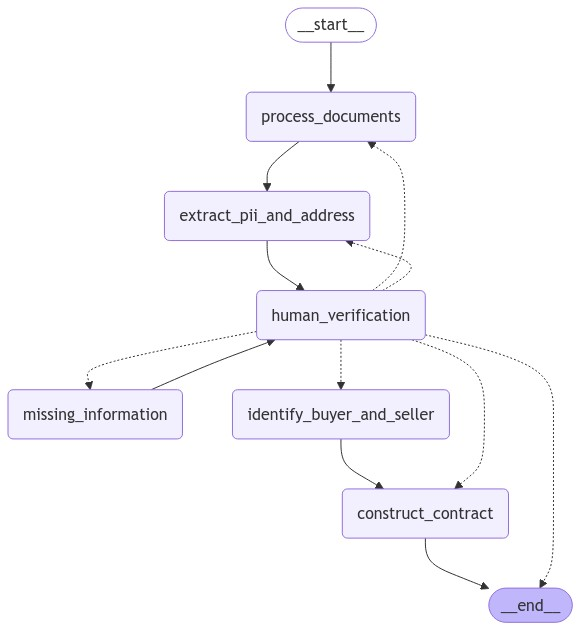

In [25]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [36]:


async def extract_text(file_path: str) -> str:
    """
    Extracts text from PDF, JPG, or text files asynchronously.
    
    Args:
        file_path (str): Path to the file to extract text from.
    
    Returns:
        str: Extracted text from the file.
    """
    if file_path.lower().endswith('.pdf'):
        try:
            loader = PyPDFLoader(file_path)
            pages = await asyncio.to_thread(loader.load)
            return "\n".join(page.page_content for page in pages)
        except ImportError:
            return "Error: PyPDFLoader not available. Please install langchain."
    elif file_path.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:
            def process_image():
                results = reader.readtext(file_path)
                return ' '.join([result[1] for result in results])
            return await asyncio.to_thread(process_image)
        except Exception as e:
            return f"Error processing image: {str(e)}"
    else:
        try:
            async with aiofiles.open(file_path, mode='r') as f:
                return await f.read()
        except Exception as e:
            return f"Error reading file: {str(e)}"

async def process_documents(state: ContractState) -> ContractState:
    documents = get_documents()  # This function should return a list of file paths.
    results = {}
    for doc in documents:
        try:
            text = await extract_text(doc)
            results[os.path.basename(doc)] = text
        except Exception as e:
            results[os.path.basename(doc)] = f"Error processing file: {str(e)}"
    state.extracted_texts = results
    return state

async def extract_pii_and_address(state: ContractState) -> ContractState:
    extracted_texts = state.extracted_texts
    print(f"Documents found: {len(extracted_texts)}")

    if not extracted_texts:
        print("No documents found or processed in the data folder.")
        return state

    new_state = deepcopy(state)
    new_state.pii_data = []

    for doc, extracted_text in extracted_texts.items():
        print(f"Processing document: {doc}")
        try:
            if not extracted_text or extracted_text.startswith("Error"):
                print(f"Unable to process text from {doc}: {extracted_text}")
                continue

            pii_response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": extracted_text}
                ],
                functions=[{
                    "name": "extract_pii_data",
                    "description": "Extracts the person's full name and address from the provided text.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "name": {"type": "string", "description": "Full name of the person."},
                            "address": {"type": "string", "description": "Residential address of the person."}
                        },
                        "required": ["name", "address"]
                    }
                }],
                function_call={"name": "extract_pii_data"}
            )

            function_call = pii_response.choices[0].message.function_call
            if function_call and function_call.arguments:
                pii_data = json.loads(function_call.arguments)
                new_state.pii_data.append({"document": doc, "data": pii_data})
                print(f"Extracted PII from {doc}: {pii_data}")
            else:
                print(f"No PII data extracted from {doc}")

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON response for {doc}: {str(e)}")
        except Exception as e:
            print(f"Unexpected error processing {doc}: {str(e)}")

    if not new_state.pii_data:
        print("Failed to extract PII from any document.")

    return new_state

async def human_verification(state: ContractState) -> ContractState:
    if isinstance(state.pii_data, list) and len(state.pii_data) > 0:
        # Accessing the extracted PII data properly
        name = state.pii_data[0]["data"].get("name", "")
        address = state.pii_data[0]["data"].get("address", "")

        if not name or not address:
            state.messages.append(AIMessage(content="No valid name or address found for verification."))
            return state

        # Generate a verification question based on the extracted PII data
        verification_prompt = f"Generate a simple yes/no question to verify this information: Name: {name}, Address: {address}"
        
        question_response = await client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": verification_prompt}
            ],
            max_tokens=50
        )
        
        verification_question = question_response.choices[0].message.content.strip()
        
        # Add the verification question to the state messages
        state.messages.append(AIMessage(content=f"Human verification required. {verification_question}"))
        
        # Simulate a human response for testing purposes
        simulated_human_response = "Yes, the information is correct."
        state.messages.append(HumanMessage(content=simulated_human_response))
        
        # Evaluate the response
        evaluation_prompt = f"Question: {verification_question}\nResponse: {simulated_human_response}\n\nDoes this response indicate that the information is correct? Respond with 'VERIFIED' if it does, or 'NOT VERIFIED' if it doesn't."
        
        evaluation_response = await client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": evaluation_prompt}
            ],
            max_tokens=10
        )
        
        evaluation = evaluation_response.choices[0].message.content.strip()
        
        if evaluation == "VERIFIED":
            state.messages.append(AIMessage(content="Human verification successful. Proceeding with the process."))
        else:
            state.messages.append(AIMessage(content="Human verification failed. Please check the information and try again."))
            return END
    else:
        state.messages.append(AIMessage(content="No PII data found for verification."))

    return state

# Create the graph
graph = StateGraph(ContractState)

# Add nodes
# Removing extract_text node as it doesn't conform to ContractState
graph.add_node("process_documents", process_documents)
graph.add_node("extract_pii_and_address", extract_pii_and_address)
graph.add_node("human_verification", human_verification)
graph.add_node("missing_information", missing_information)
graph.add_node("identify_buyer_and_seller", identify_buyer_and_seller)
graph.add_node("construct_contract", construct_contract)

# Define edges
graph.set_entry_point("process_documents")
graph.add_edge("process_documents", "extract_pii_and_address")
graph.add_edge("extract_pii_and_address", "human_verification")
graph.add_conditional_edges("human_verification", lambda state: "missing_information" if "missing" in state else "identify_buyer_and_seller")
graph.add_edge("missing_information", "human_verification")
graph.add_edge("identify_buyer_and_seller", "construct_contract")
graph.add_edge("construct_contract", END)

# Compile the graph
app = graph.compile()

In [37]:
import nest_asyncio
import json

# Apply nest_asyncio for Jupyter/IPython compatibility
nest_asyncio.apply()

# Define a function to test the state graph
async def test_graph():
    # Create the initial contract state
    initial_state = ContractState(messages=[], extracted_texts={})
    
    # Run the compiled app (state graph) on the initial state
    try:
        result_state = await app.ainvoke(initial_state)
        
        # Print the final state messages and PII data to verify correct behavior
        print("\nFinal Messages:")
        for message in result_state.messages:
            print(message.content)
        
        if hasattr(result_state, 'pii_data') and result_state.pii_data:
            print("\nExtracted PII Data:")
            for item in result_state.pii_data:
                print(f"\nDocument: {item['document']}")
                print(json.dumps(item['data'], indent=2))

    except Exception as e:
        print(f"Error during graph execution: {str(e)}")

# Run the test
await test_graph()


Total files in data: 2
Files found: ['Screenshot 2024-10-08 at 13.22.38.png', 'Screenshot 2024-10-08 at 13.24.00.png']
Documents to process: 2
Documents found: 2
Processing document: Screenshot 2024-10-08 at 13.22.38.png
Extracted PII from Screenshot 2024-10-08 at 13.22.38.png: {'name': 'ISPILANTE SENTIMENT BRUSLI', 'address': 'Videle, Jud: Teleorman, Sos: Giurgiuluinr:1, 695 TR'}
Processing document: Screenshot 2024-10-08 at 13.24.00.png
Extracted PII from Screenshot 2024-10-08 at 13.24.00.png: {'name': 'ELENA VASILESCU', 'address': 'Mun: Bucuresti Sec: 5 Str _ Nicolae Iorga nr.3 900 B'}
Error during graph execution: 'list' object has no attribute 'get'


In [41]:
import nest_asyncio

# Apply nest_asyncio to run async functions in Jupyter/IPython environments
nest_asyncio.apply()

# Define a function to test the state graph
async def test_graph():
    # Create the initial contract state
    initial_state = ContractState(messages=[], extracted_texts={})

    # Run the compiled app (state graph) on the initial state
    try:
        result_state = await app.ainvoke(initial_state)
        
        # Print the final state messages
        print("\nFinal Messages:")
        for message in result_state.messages:
            print(message.content)
        
        # Print any extracted PII data
        if hasattr(result_state, 'pii_data') and result_state.pii_data:
            print("\nExtracted PII Data:")
            for item in result_state.pii_data:
                print(f"\nDocument: {item['document']}")
                print(json.dumps(item['data'], indent=2))

        # Print any extracted texts (if available)
        if hasattr(result_state, 'extracted_texts') and result_state.extracted_texts:
            print("\nExtracted Texts:")
            for filename, text in result_state.extracted_texts.items():
                print(f"File: {filename}")
                print(f"Text Extract: {text[:100]}...")  # Print the first 100 characters of each text

    except Exception as e:
        print(f"Error during graph execution: {str(e)}")

# Run the test function
await test_graph()


Total files in data: 2
Files found: ['Screenshot 2024-10-08 at 13.22.38.png', 'Screenshot 2024-10-08 at 13.24.00.png']
Documents to process: 2
Documents found: 2
Processing document: Screenshot 2024-10-08 at 13.22.38.png
Extracted PII from Screenshot 2024-10-08 at 13.22.38.png: {'name': 'SENTIMENT BRUSLI ISPILANTE', 'address': 'Videle Jud: Teleorman Sos: Giurgiuluinr:1 695 TR'}
Processing document: Screenshot 2024-10-08 at 13.24.00.png
Extracted PII from Screenshot 2024-10-08 at 13.24.00.png: {'name': 'ELENA VASILESCU', 'address': 'Mun: Bucuresti Sec: 5 Str _ Nicolae Iorga nr.3 900 B'}
Error during graph execution: 'list' object has no attribute 'get'


In [42]:


async def extract_text(file_path: str) -> str:
    """
    Extracts text from PDF, JPG, or text files asynchronously.
    
    Args:
        file_path (str): Path to the file to extract text from.
    
    Returns:
        str: Extracted text from the file.
    """
    if file_path.lower().endswith('.pdf'):
        try:
            loader = PyPDFLoader(file_path)
            pages = await asyncio.to_thread(loader.load)
            return "\n".join(page.page_content for page in pages)
        except ImportError:
            return "Error: PyPDFLoader not available. Please install langchain."
    elif file_path.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:
            def process_image():
                results = reader.readtext(file_path)
                return ' '.join([result[1] for result in results])
            return await asyncio.to_thread(process_image)
        except Exception as e:
            return f"Error processing image: {str(e)}"
    else:
        try:
            async with aiofiles.open(file_path, mode='r') as f:
                return await f.read()
        except Exception as e:
            return f"Error reading file: {str(e)}"

async def process_documents(state: ContractState) -> ContractState:
    documents = get_documents()  # This function should return a list of file paths.
    results = {}
    for doc in documents:
        try:
            text = await extract_text(doc)
            results[os.path.basename(doc)] = text
        except Exception as e:
            results[os.path.basename(doc)] = f"Error processing file: {str(e)}"
    state.extracted_texts = results
    return state

async def extract_pii_and_address(state: ContractState) -> ContractState:
    extracted_texts = state.extracted_texts
    print(f"Documents found: {len(extracted_texts)}")

    if not extracted_texts:
        print("No documents found or processed in the data folder.")
        return state

    new_state = deepcopy(state)
    new_state.pii_data = []

    for doc, extracted_text in extracted_texts.items():
        print(f"Processing document: {doc}")
        try:
            if not extracted_text or extracted_text.startswith("Error"):
                print(f"Unable to process text from {doc}: {extracted_text}")
                continue

            pii_response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": extracted_text}
                ],
                functions=[{
                    "name": "extract_pii_data",
                    "description": "Extracts the person's full name and address from the provided text.",
                    "parameters": {
                        "type": "object",
                        "properties": {
                            "name": {"type": "string", "description": "Full name of the person."},
                            "address": {"type": "string", "description": "Residential address of the person."}
                        },
                        "required": ["name", "address"]
                    }
                }],
                function_call={"name": "extract_pii_data"}
            )

            function_call = pii_response.choices[0].message.function_call
            if function_call and function_call.arguments:
                pii_data = json.loads(function_call.arguments)
                new_state.pii_data.append({"document": doc, "data": pii_data})
                print(f"Extracted PII from {doc}: {pii_data}")
            else:
                print(f"No PII data extracted from {doc}")

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON response for {doc}: {str(e)}")
        except Exception as e:
            print(f"Unexpected error processing {doc}: {str(e)}")

    if not new_state.pii_data:
        print("Failed to extract PII from any document.")

    return new_state

async def human_verification(state: ContractState) -> ContractState:
    if isinstance(state.pii_data, list) and len(state.pii_data) > 0:
        # Accessing the extracted PII data properly
        name = state.pii_data[0].get("data", {}).get("name", "")
        address = state.pii_data[0].get("data", {}).get("address", "")

        if not name or not address:
            state.messages.append(AIMessage(content="No valid name or address found for verification."))
            return state

        # Generate a verification question based on the extracted PII data
        verification_prompt = f"Generate a simple yes/no question to verify this information: Name: {name}, Address: {address}"
        
        question_response = await client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": verification_prompt}
            ],
            max_tokens=50
        )
        
        verification_question = question_response.choices[0].message.content.strip()
        
        # Add the verification question to the state messages
        state.messages.append(AIMessage(content=f"Human verification required. {verification_question}"))
        
        # Simulate a human response for testing purposes
        simulated_human_response = "Yes, the information is correct."
        state.messages.append(HumanMessage(content=simulated_human_response))
        
        # Evaluate the response
        evaluation_prompt = f"Question: {verification_question}\nResponse: {simulated_human_response}\n\nDoes this response indicate that the information is correct? Respond with 'VERIFIED' if it does, or 'NOT VERIFIED' if it doesn't."
        
        evaluation_response = await client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": evaluation_prompt}
            ],
            max_tokens=10
        )
        
        evaluation = evaluation_response.choices[0].message.content.strip()
        
        if evaluation == "VERIFIED":
            state.messages.append(AIMessage(content="Human verification successful. Proceeding with the process."))
        else:
            state.messages.append(AIMessage(content="Human verification failed. Please check the information and try again."))
            return END
    else:
        state.messages.append(AIMessage(content="No PII data found for verification."))

    return state

# Create the graph
graph = StateGraph(ContractState)

# Add nodes
# Removing extract_text node as it doesn't conform to ContractState
graph.add_node("process_documents", process_documents)
graph.add_node("extract_pii_and_address", extract_pii_and_address)
graph.add_node("human_verification", human_verification)
graph.add_node("missing_information", missing_information)
graph.add_node("identify_buyer_and_seller", identify_buyer_and_seller)
graph.add_node("construct_contract", construct_contract)

# Define edges
graph.set_entry_point("process_documents")
graph.add_edge("process_documents", "extract_pii_and_address")
graph.add_edge("extract_pii_and_address", "human_verification")
graph.add_conditional_edges("human_verification", lambda state: "missing_information" if "missing" in state else "identify_buyer_and_seller")
graph.add_edge("missing_information", "human_verification")
graph.add_edge("identify_buyer_and_seller", "construct_contract")
graph.add_edge("construct_contract", END)

# Compile the graph
app = graph.compile()

print(f"PII data type: {type(state.pii_data)}")
print(f"Extracted data: {state.pii_data}")


NameError: name 'state' is not defined